Text shazam

Data gathering

analysis of 2 or 3 different kind of algorithms we will use: kNN, maxent, logistic regression, deep learning, and support vector machines.

each method has a different pre processing and strengths and interpretatio


kNN- tokenizing, all lower case, removing common words, lematisize, tagging words as preposition/conjunction/etc,  TF IDF

Do we remove stop words, or not?
Do we stem or lemmatize our text data, or leave the words as is?
Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
Do we stick with English words only or do we allow for other languages?
Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?

In [1]:
import seaborn as sns

import numpy as np

import random

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import re
import os

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from scipy.interpolate import make_interp_spline

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Concatenate, Dropout, BatchNormalization, Embedding, Input, LSTM, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,to_categorical

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from tqdm import tqdm

import Levenshtein
from nltk.stem import PorterStemmer
import string


#set working directory
os.chdir('C:\\Users\\Aarry\\Downloads\\Text-Shazam')


In [2]:
import shutil

def zip_folder(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

# Example usage
#folder_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT/Raw_Songs_DataBase'  # Replace with the path to your folder
#zip_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT'  # Replace with the desired path and name for the zip file

#zip_folder(folder_path, zip_path)

In [3]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [4]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 15

In [5]:
#get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase2")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
#artists = random.sample(artists_all, NUMBER_OF_ARTISTS)
artists = sorted(artists)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    #path_to_rid = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

In [6]:
save_dir = os.path.join(os.getcwd(), "saved_plots")

In [7]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()

Now let us get some data about the songs

Number of songs : 26164
Number of artists : 232
Average number of songs per artist : 112
Maximum number of songs: 201
Minimum number of songs: 2


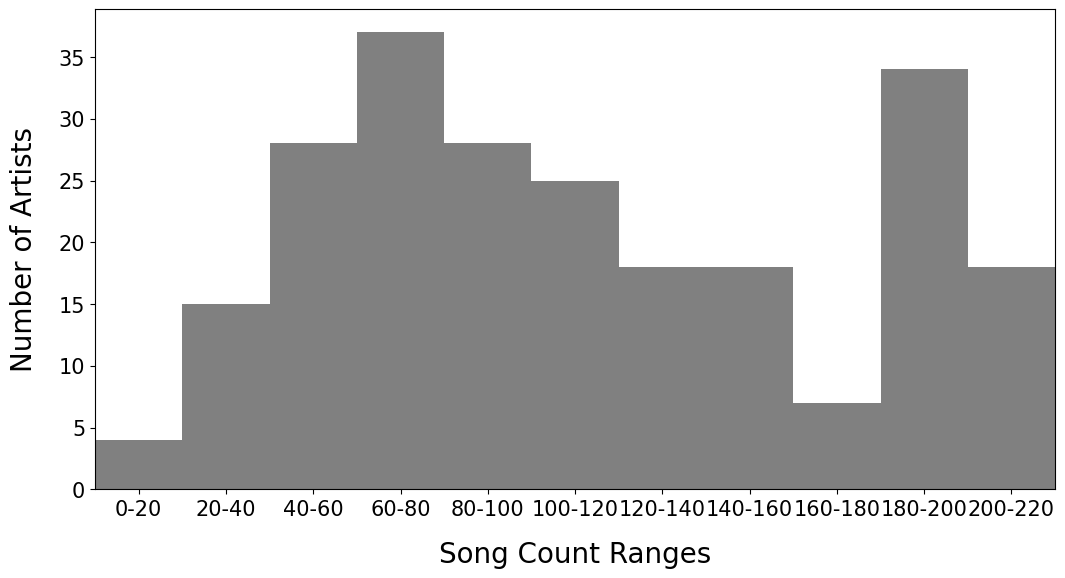

In [8]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

max_value = max(songs_per_artist.values())
min_value = min(songs_per_artist.values())

print(f"Maximum number of songs: {max_value}")
print(f"Minimum number of songs: {min_value}")

# Define the bins for different song count ranges
max_bin = ((max_value // 20) + 1) * 20
bins = [i*20 for i in range((max_bin//20) + 1)]

# Initialize counts for each bin
bin_counts = [0] * (len(bins) - 1)

# Count the number of artists falling into each bin
for value in songs_per_artist.values():
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            bin_counts[i] += 1
            break

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

bar_lefts = range(len(bin_counts))
bar_heights = bin_counts

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')

plt.xlabel('Song Count Ranges', fontsize=20, labelpad=15)
plt.ylabel('Number of Artists', fontsize=20, labelpad=15)

plt.xticks(range(len(bin_counts)), [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)], fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(-0.5, len(bin_counts) - 0.5)

save_path = os.path.join(save_dir, f'distribution_songs_start.png')
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [9]:
def flatten(text):
    text = [word for sentence in text for word in sentence]
    return text

In [10]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";{}]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists

    
    #remove empty lines
    text = [line for line in text if len(line)!=0]
    
    
    #remove all expressions in between brackets and empty words
    text = [ [word.strip() for word in line if len(word) != 0 and word[0]!= "["] for line in text]
    
    #remobe empty lines again
    text = [line for line in text if len(line)!=0]
    nb_lines = len(text)
    
    #stemmatization
    ps = PorterStemmer()
    text = [[ps.stem(word) for word in line] for line in text]
    
    nb_words = 0
    for line in text:
        nb_words += len(line)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

Let's vizualize the data

In [11]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [12]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0


In [13]:
def plot_box_graph(features, save=None):
    

    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [arts_dict_op[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)
        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])

        xtick_labels = [arts_dict_op[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        
        plt.show()
        
def plot_bar_graph(feature, save = None):

    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

   
    plt.bar(np.arange(len(to_plot)), to_plot, color='gray')
    xtick_labels = [arts_dict_op[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)
    plt.title(feature)
    
    if save != None:
        save_path = os.path.join(save_dir, f'plot_{feature}.png')
        plt.savefig(save_path)

    plt.show()

In [14]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [15]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,RID_PRIMARY:NEED:ORALITY,RID_PRIMARY:SENSATION:HARD,RID_PRIMARY:ICARIAN:IMAGERY:DESCENT,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:RANDOM:MOVEMENT,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY:SENSATION:ODOR,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.766234,49.350649,16.883117
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.240506,51.898734,8.860759
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.222222,51.111111,6.666667
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.813559,47.457627,23.728814
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.500000,50.000000,37.500000


In [16]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 357 duplicates


In [17]:
df = df[df['Nb_Words'] >= 50]
s3 = df.shape[0]

print(f'Dropped {s2 - s3} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} intros and outros')

Dropped 530 songs that were too short
Dropped 25 intros and outros


In [18]:
def dropping_artists():
    # Compute the count of instances for each artist
    artist_counts = df['Artist'].value_counts()

    # Identify artists with counts less than 50
    artists_to_drop = artist_counts[artist_counts < 90].index

    # Create a boolean mask indicating rows to be dropped
    mask = df['Artist'].isin(artists_to_drop)

    # Filter and drop the corresponding rows from the DataFrame
    df.drop(df[mask].index, inplace=True)

    l1 = len(artists)
    # Remove the artists from the artists array
    new_artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
    dropped_artists = [art for art in artists if arts_dict[art] in artists_to_drop]
    for art in dropped_artists:
        del arts_dict_op[arts_dict[art]]
        del arts_dict[art]

    l2 = len(new_artists)


    s5 = df.shape[0]
    print(f'Dropped {l1 - l2} artists that had too few songs : -{s4 - s5} songs')
    
dropping_artists()

Dropped 99 artists that had too few songs : -5419 songs


In [19]:
#FUNCTIONS TO MEASURE SIMILARITY

def levenshtein_similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / (max_length + 1)
    return similarity

def jaccard_similarity(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / (union + 1)
    return similarity

In [20]:
# Create a mask to identify the rows to drop
mask = np.zeros(len(df), dtype=bool)


for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # Filter rows with the same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    
    # Calculate similarity scores between song1 and duplicate rows
    similarity_scores_lev = duplicate_rows["Raw_Lyrics"].apply(lambda x: levenshtein_similarity(song1, x))
    
    # Identify rows with similarity scores above 0.8
    similar_rows_lev = duplicate_rows[similarity_scores_lev > 0.8]

    
    
    df.drop(similar_rows_lev.index, inplace=True)

# Drop the marked rows using the mask
#df.drop(df.index[mask], inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 6478 covers


In [21]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Reba McEntire (199 songs)
Artist with the least songs: Chet Baker (78 songs)


In [22]:
def undersampling():
    # Identify artists with a total number of songs greater than 130
    artists_above_threshold = artist_counts[artist_counts > 130].index

   
    for artist in artists_above_threshold:
        # Get the indices of songs by the current artist
        artist_indices = df[df['Artist'] == artist].index

        # Calculate the number of songs to be dropped
        songs_to_drop = len(artist_indices) - 130

        # Randomly select and drop songs until count reaches 130
        songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
        df.drop(artist_indices.difference(songs_to_keep), inplace=True)

    s7 = df.shape[0]
    print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

In [23]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(arts_dict)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(arts_dict))}')

AFTER CLEANING

Number of songs : 19329
Number of artists : 133
Average number of songs per artist : 145


In [24]:
glove_file = 'glove.6B.300d.txt'
tmp_file = 'glove_word2vec.txt'
glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)


C:\Users\Aarry\AppData\Local\Temp\ipykernel_20456\3814666020.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


In [25]:
songs = df["Lyrics"].to_list()
songs_flatten = [[word for line in song for word in line]for song in songs]
df["Lyrics"]=songs_flatten
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,RID_PRIMARY:NEED:ORALITY,RID_PRIMARY:SENSATION:HARD,RID_PRIMARY:ICARIAN:IMAGERY:DESCENT,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:RANDOM:MOVEMENT,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY:SENSATION:ODOR,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[take, it, easi, with, me, pleas, touch, me, g...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.766234,49.350649,16.883117
1,"[ahhaha, ahaaaah, ahhaha, ahaaaah, ahhaha, kee...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.240506,51.898734,8.860759
2,"[day, is, dawn, and, i, must, go, you'r, aslee...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.222222,51.111111,6.666667
3,"[i'll, never, know, whi, i, had, to, go, whi, ...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.813559,47.457627,23.728814
5,"[make, somebodi, happi, is, a, question, of, g...",34,200,\nMaking somebody happy is a question of give ...,bangaboomerang,0,0.011673,0.000000,0.019455,0.143969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.493671,22.784810,17.721519


In [26]:
artists_set = random.sample(list(arts_dict_op.keys()), 15)

In [27]:
new_df = df.iloc[:, [0, 5]]
new_df = new_df[new_df['Artist'].isin(artists_set)]
new_df.head()

,Lyrics,Artist
4794,"[it, begin, to, tell, 'round, midnight, midnig...",44
4797,"[all, or, noth, at, all, half, a, love, never,...",44
4800,"[you, must, rememb, thi, a, kiss, is, still, a...",44
4801,"[the, fall, leav, drift, by, the, window, the,...",44
4804,"[some, folk, were, meant, to, live, in, clover...",44


In [28]:
df2 = new_df.copy()
df2['song_lyric'] = df2['Lyrics'].apply(lambda x: ' '.join(x))
df2.drop("Lyrics", axis=1, inplace=True)
df2.head()

,Artist,song_lyric
4794,44,it begin to tell 'round midnight midnight i do...
4797,44,all or noth at all half a love never appeal to...
4800,44,you must rememb thi a kiss is still a kiss a s...
4801,44,the fall leav drift by the window the autumn l...
4804,44,some folk were meant to live in clover but the...


In [29]:

## one hot encoding 
artist = new_df.iloc[:, -1].values.copy()
artist = artist.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')

# Fit and transform the 'artist' array using the encoder
artist_encoded = encoder.fit_transform(artist)
artist_encoded.shape

(2333, 15)

In [30]:
MAX_NB_WORDS = 100
MAX_SEQUENCE_LENGTH = 1000
num_fts = 300
n_art = 15

In [31]:
def loading_embeddings():
    """ loading glove embeddings """
    embeddings_index = {}
    with open('glove.6B.300d.txt', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [32]:
def prepare_embedding_matrix(word_index):
    """ preparing embedding matrix with our data set """

    embeddings_index = loading_embeddings()
    num_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((num_words + 1, num_fts))
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

In [33]:
def model_generation(embedding_matrix, num_words):
    """ model generation """
    embedding_layer = Embedding(num_words + 1,
                                num_fts,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
    l_cov1 = Dropout(0.8)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
    l_cov2 = Dropout(0.8)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(n_art, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

In [34]:
def model_generation2(embedding_matrix, num_words):
    """ model generation """
    embedding_layer = Embedding(num_words + 1,
                                num_fts,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(512, 5, activation='relu')(embedded_sequences)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(512, 5, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(512, 5, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(n_art, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

In [35]:
def model_generation3(embedding_matrix, num_words):
    """ model generation """
    embedding = Embedding(num_words + 1,
                                num_fts,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    model.add(embedding)
    model.add(Dropout(0.3))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.6))
    model.add(Dense(1, activation='relu'))
    # compile the model
    optimzer = Adam(clipvalue=0.5) # clip value to avoid the gradient exploding

    model.compile(optimizer=optimzer, 
                loss='binary_crossentropy', 
                metrics=['acc'])
    return model

In [36]:
def vectorizing_data(df):
    """ vectorizing and splitting the data for training, testing, validating """
    # vectorizing the text samples and labels into a 2D integer tensor
    label_s = df['Artist'].tolist()
    l = list(set(label_s))
    l.sort()
    labels_index = dict([(j,i) for i, j in enumerate(l)]) 
    labels = [labels_index[i] for i in label_s]

    print('Found %s texts.' % len(df['song_lyric']))
    print('labels_index --- ', labels_index)

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(df['song_lyric'])
    sequences = tokenizer.texts_to_sequences(df['song_lyric'])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    """
    if not home_path + 'word_index_tutorial.pickle' in os.listdir():
        with open(home_path + 'word_index_tutorial.pickle', 'wb') as handle:
            pickle.dump(word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    """

    df = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    labels = to_categorical(np.asarray(labels))
    print('Shape of df tensor:', df.shape)
    print('Shape of label tensor:', labels.shape)

    # randomizing and splitting the df into a training set, test set and a validation set
    indices = np.arange(df.shape[0])
    np.random.shuffle(indices)
    df = df[indices]
    labels = labels[indices]
    num_validation_samples = int(0.2* df.shape[0])

    x_train = df[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_test = df[-num_validation_samples:]
    y_test = labels[-num_validation_samples:]
    return x_train, y_train, x_test, y_test, word_index 

In [37]:
def generate_lyrics_embedding(lyrics):
    embedding_dim = model.vector_size
    embedding = np.zeros(embedding_dim)
    word_count = 0

    for word in lyrics:
        if word in model:
            embedding += model[word]
            word_count += 1

    if word_count > 0:
        embedding /= word_count

    return embedding


In [38]:
new_df['lyrics_embedding'] = new_df['Lyrics'].apply(generate_lyrics_embedding)
columns = new_df.columns.tolist()
columns[1], columns[-1] = columns[-1], columns[1]
new_df = new_df[columns]

#new_df['all_vals']= None
#for i in range(len(new_df)):
#    new_df.at[i, 'all_vals'] = np.concatenate((newm[i], new_df.loc[i, 'lyrics_embedding']))

new_df['Artist'] = artist_encoded.tolist()
new_df.drop(new_df.columns[0], axis=1, inplace=True)
new_df.head()

#new_df = new_df.iloc[:, 1:]

# Interchange the new first and second columns
#new_df = new_df.iloc[:, [1, 0] + list(range(2, new_df.shape[1]))]

new_df.head()

,lyrics_embedding,Artist
4794,"[-0.04132837974951447, -0.02647748897288693, -...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4797,"[-0.16561758380691063, 0.07456439145311902, -0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4800,"[-0.14594313533663159, 0.06779485179277339, -0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4801,"[-0.14334343965165317, -0.007748651062138378, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4804,"[-0.11268251045352087, 0.07093704061247096, -0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [39]:
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42)
train_df.head()
x_train2 = train_df['lyrics_embedding'].to_numpy()
y_train2 = train_df['Artist'].to_numpy()
x_test2 = test_df['lyrics_embedding'].to_numpy()
y_test2 = test_df['Artist'].to_numpy()
xtlen = len(x_train2)
ytlen = len(x_test2)

x_train = np.zeros((xtlen,num_fts))
y_train = np.zeros((xtlen,15))
x_test = np.zeros((ytlen,num_fts))
y_test = np.zeros((ytlen,15))
for i in range(xtlen):
    for j in range(num_fts):
        x_train[i][j] = x_train2[i][j]
    for j in range(15):
        y_train[i][j] = y_train2[i][j]
for i in range(ytlen):
    for j in range(num_fts):
        x_test[i][j] = x_test2[i][j]
    for j in range(15):
        y_test[i][j] = y_test2[i][j]


x_train.shape

(1866, 300)

In [40]:
def simple_model(input_shape, num_classes):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.08))  # Adjust dropout rate as desired
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.08)) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.08))  # Adjust dropout rate as desired
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    #optimizer = keras.optimizers.Adam()
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
def td_model(input_shape: tuple, num_classes: int):
    """
    Returns a compiled keras Conv2D model
    
    :param tuple input_shape: shape of ONE example as passed to the first layer
    :param int num_classes: number of output classes as passed to the last layer
    """
    model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(32, 3, padding='same', activation=tf.nn.relu, input_shape=input_shape),
                                        tf.keras.layers.Conv1D(32, 3, activation=tf.nn.relu),
                                        tf.keras.layers.Dropout(0.7),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPooling1D(pool_size=2),
                                        tf.keras.layers.Conv1D(64, 3, activation=tf.nn.relu),
                                        tf.keras.layers.Conv1D(64, 3, activation=tf.nn.relu),
                                        tf.keras.layers.Dropout(0.8),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPooling1D(pool_size=(2)),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(512, activation='relu'),
                                        tf.keras.layers.Dropout(0.7),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(num_classes, activation='softmax')])
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'])
    



    return model
    

In [42]:
# Define the input shape
input_shape = (num_fts, 1)  # Assuming input arrays are 1D with a length of 50

# Define the number of output classes
num_classes = n_art

smodel = simple_model(input_shape, num_classes)
early_stopping = keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)


x_train = x_train.reshape(x_train.shape[0], input_shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], input_shape[0], 1)



In [43]:
def trainer(model, x_train, y_train, batch_size, epochs, validation_data, callbacks):

    totes = 0
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data,callbacks=callbacks)
    # Evaluate the model on the test data
    _, accuracys = model.evaluate(x_test, y_test)
    totes += accuracys
    #Print the accuracy
    print('Test accuracy:', totes*100)
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.show()
    save_path = os.path.join(save_dir, 'accuracy_vs_valacc.png')        
    plt.savefig(save_path, bbox_inches='tight')

NOW DOING MY MODEL
Epoch 1/200
30/30 [==============================] - 19s 213ms/step - loss: 3.9145 - accuracy: 0.0997 - val_loss: 2.7060 - val_accuracy: 0.0343
Epoch 2/200
30/30 [==============================] - 5s 172ms/step - loss: 2.8816 - accuracy: 0.1206 - val_loss: 2.7108 - val_accuracy: 0.0792
Epoch 3/200
30/30 [==============================] - 5s 178ms/step - loss: 2.7185 - accuracy: 0.1388 - val_loss: 2.7354 - val_accuracy: 0.0428
Epoch 4/200
30/30 [==============================] - 5s 177ms/step - loss: 2.6520 - accuracy: 0.1629 - val_loss: 2.7539 - val_accuracy: 0.0792
Epoch 5/200
30/30 [==============================] - 5s 169ms/step - loss: 2.5582 - accuracy: 0.1833 - val_loss: 2.7685 - val_accuracy: 0.1178
Epoch 6/200
30/30 [==============================] - 5s 163ms/step - loss: 2.4630 - accuracy: 0.2058 - val_loss: 2.7589 - val_accuracy: 0.1113
Epoch 7/200
30/30 [==============================] - 5s 171ms/step - loss: 2.4312 - accuracy: 0.2181 - val_loss: 2.7627 - 

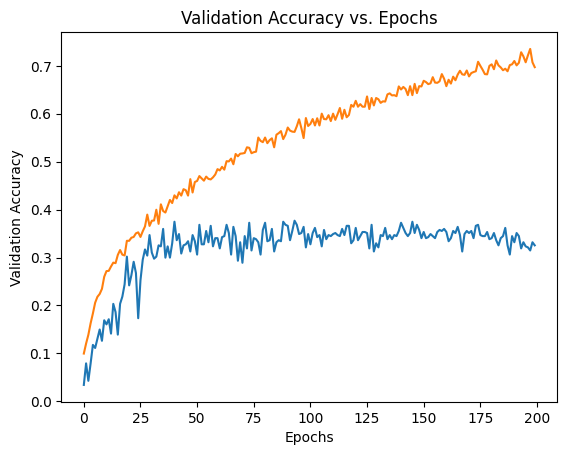

<Figure size 640x480 with 0 Axes>

In [44]:
batch_size=64
epochs = 200
print("NOW DOING MY MODEL")
trainer(model = smodel, x_train = x_train, y_train =y_train, batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),callbacks=[early_stopping] )

In [45]:
def predict(model, x: np.array, labels: list) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    ypred = model.predict(x)
    ypc = np.argmax(ypred, axis = 1)
    class_pred = [labels[i] for i in ypc]
    return class_pred

In [46]:
def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list):
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    ypred = predict(model, x_test,labels)
    ypl = [labels[np.where(i==1)[0][0]] for i in y_test]
    nums = [[ 0 for _ in range(15)] for _ in range(15)]
    for i in range(len(ypl)):
        nums[labels.index(ypl[i])][labels.index(ypred[i])] += 1
   
    pred_labels = [i for i in labels]
    act_labels = [i for i in labels]
    df4 = pd.DataFrame(nums, act_labels, pred_labels)
        
        
                      
    # making the table look fancy
    df4.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    return df4

In [47]:

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()






In [48]:
def get_values(dictionary, keys):
    values = []
    for key in keys:
        if key in dictionary:
            values.append(dictionary[key])
    return values

art_set = get_values(arts_dict_op, artists_set)
art_set

['Pointer Sisters',
 'Opeth',
 'Donna Summer',
 'In Flames',
 'UB40',
 'Lana Del Rey',
 'Slayer',
 'Reba McEntire',
 'Isley Brothers',
 'Ray Charles',
 'Dennis Brown',
 'Eminem',
 'Chet Baker',
 'Fairport Convention',
 'Queen']

15/15 [==============================] - 1s 13ms/step


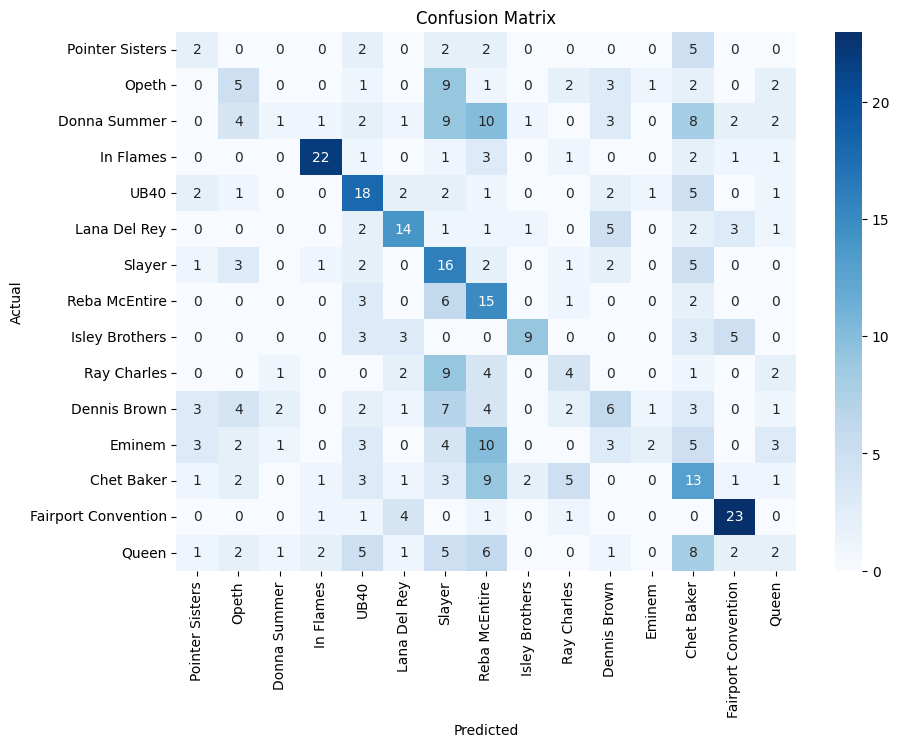

In [49]:
sconf = confusion_matrix(smodel, x_test, y_test, art_set)
plot_confusion_matrix(sconf)
# Plot the confusion matrix


In [50]:
def calculate_f1_score(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    f1_scores = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = confusion_matrix.iloc[i, i]
        fp = confusion_matrix.iloc[:, i].sum() - tp
        fn = confusion_matrix.iloc[i, :].sum() - tp
        
        f1_scores[i] = 2 * tp / (2*tp +fp + fn)
    
    mean_f1_score = np.mean(f1_scores)
    
    return mean_f1_score


In [51]:

calculate_f1_score(sconf)

0.309606448163349

In [52]:
def prob_graph(model, example_index, x_test):
    for i in example_index:
        # Reshape the example for prediction
        example = x_test[i].reshape(1, input_shape[0], 1)

        # Make predictions on the example
        predictions = model.predict(example)

        # Get the predicted probabilities for each class
        probabilities = predictions[0]

        # Plot the probabilities in a bar plot
        plt.bar(art_set, probabilities, color='gray')
        plt.title('Class Probabilities')
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.xticks(range(len(art_set)), art_set, rotation=45, ha='right')  # Center and rotate x-axis labels
        plt.tight_layout()  # Ensure labels are properly displayed
        plt.show()
        save_path = os.path.join(save_dir, f'plot_prob_classes.png')        
        plt.savefig(save_path, bbox_inches='tight')




1/1 [==============================] - 0s 48ms/step


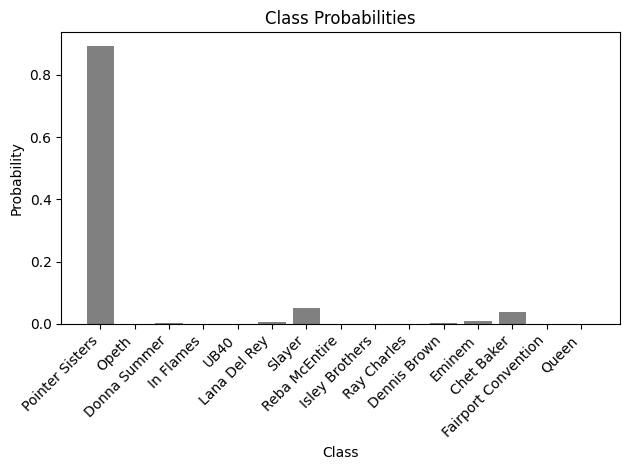

<Figure size 640x480 with 0 Axes>

In [53]:
prob_graph(model = smodel,example_index=[0], x_test=x_test)




In [54]:
df2.head()

,Artist,song_lyric
4794,44,it begin to tell 'round midnight midnight i do...
4797,44,all or noth at all half a love never appeal to...
4800,44,you must rememb thi a kiss is still a kiss a s...
4801,44,the fall leav drift by the window the autumn l...
4804,44,some folk were meant to live in clover but the...


Found 2333 texts.
labels_index ---  {44: 0, 61: 1, 66: 2, 74: 3, 78: 4, 103: 5, 106: 6, 133: 7, 164: 8, 174: 9, 178: 10, 185: 11, 186: 12, 191: 13, 220: 14}
Found 13526 unique tokens.
Shape of df tensor: (2333, 1000)
Shape of label tensor: (2333, 15)
NOW DOING GOOD MODEL #1
Epoch 1/25
30/30 [==============================] - 50s 2s/step - loss: 3.1212 - accuracy: 0.1103 - val_loss: 2.6729 - val_accuracy: 0.1266
Epoch 2/25
30/30 [==============================] - 51s 2s/step - loss: 2.5779 - accuracy: 0.1457 - val_loss: 2.6379 - val_accuracy: 0.1760
Epoch 3/25
30/30 [==============================] - 48s 2s/step - loss: 2.5038 - accuracy: 0.1709 - val_loss: 2.6291 - val_accuracy: 0.1459
Epoch 4/25
30/30 [==============================] - 47s 2s/step - loss: 2.4527 - accuracy: 0.1676 - val_loss: 2.5879 - val_accuracy: 0.1974
Epoch 5/25
30/30 [==============================] - 48s 2s/step - loss: 2.3887 - accuracy: 0.1832 - val_loss: 2.5887 - val_accuracy: 0.1159
Epoch 6/25
30/30 [=======

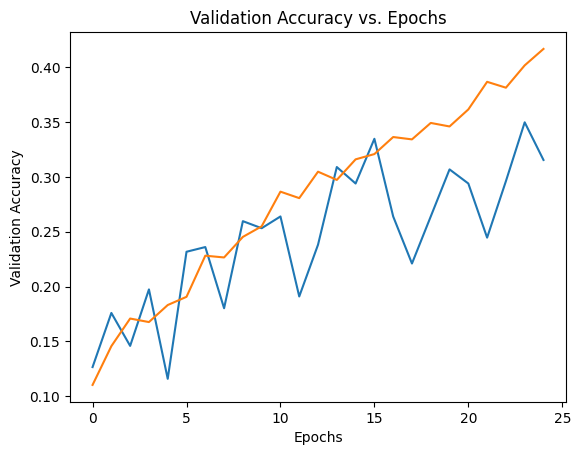

NOW DOING GOOD MODEL #2
Epoch 1/25
30/30 [==============================] - 106s 3s/step - loss: 2.6366 - accuracy: 0.0975 - val_loss: 2.5878 - val_accuracy: 0.1481
Epoch 2/25
30/30 [==============================] - 99s 3s/step - loss: 2.4950 - accuracy: 0.1521 - val_loss: 2.5555 - val_accuracy: 0.1116
Epoch 3/25
30/30 [==============================] - 108s 4s/step - loss: 2.4011 - accuracy: 0.1864 - val_loss: 2.3581 - val_accuracy: 0.1974
Epoch 4/25
11/30 [==========>...................] - ETA: 1:04 - loss: 2.3929 - accuracy: 0.1747

In [55]:

batch_size=64
epochs = 25
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

x_train, y_train, x_test, y_test, word_index = vectorizing_data(df2)

embedding_matrix, num_words = prepare_embedding_matrix(word_index)

g1model = model_generation(embedding_matrix, num_words)
g2model = model_generation2(embedding_matrix,num_words)
g3model = model_generation2(embedding_matrix,num_words)

print("NOW DOING GOOD MODEL #1")
trainer(model = g1model, x_train = x_train, y_train =y_train, batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),callbacks=[early_stopping] )
print("NOW DOING GOOD MODEL #2")
trainer(model = g2model, x_train = x_train, y_train =y_train, batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),callbacks=[early_stopping] )
print("NOW DOING GOOD MODEL #3")
trainer(model = g3model, x_train = x_train, y_train =y_train, batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),callbacks=[early_stopping] )